
# Multi-scale analysis

The central focus of landscape ecology is exploring the relationship between the spatial pattern of landscapes and the ecological processes that occur on them [1]. To that end, a crucial step is to identify the scales at which the ecological processes of interest operate [2]. Nevertheless, the appropriate scales may not be obvious, thus in practice it is usually appropriate to consider multiple spatial scales.

This notebook shows how the `MultiScaleAnalysis` class to perform analyses at multiple spatial scales, which follows the [multilandr R package](https://github.com/phuais/multilandR) [3]. As an example use case, we will explore the relationship between bird species richness collected at multiple sites in Zurich - data from Casanelles et al. (2021) [4] - and the spatial patterns of the landscape surrounding each site.

First of all, in order to run this notebook, we need to install the version of pylandstats that currently lives in the "feat-multiscale" branch of the GitHub repository. It is recommended to first install GDAL (or directly geopandas) using conda/mamba, and then install the experimental pylandstats version using pip as in:

    pip install https://github.com/martibosch/pylandstats/archive/feat-multiscale.zip

We will continue with some imports, definitions and data processing.

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import seaborn as sns
from rasterio import plot
from scipy.stats import variation
from sklearn import ensemble, model_selection

import pylandstats as pls

# viz
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]


def aic(model, X_train, y_train, X_test, y_test, **fit_kwargs):
    """Compute Akaike Information Criterion (AIC) for the test set."""
    return 2 * X_train.shape[1] - 2 * np.log(
        np.sum(
            (y_test - model().fit(X_train, y_train, **fit_kwargs).predict(X_test)) ** 2
        )
    )

## 1. Data processing

For each of the sites with species data, we will compute landscape metrics for the surrounding landscape. In order to explore multiple spatial scales, we will first generate multiple circular buffers of increasing radii around each site. Then, the metrics will be computed separately for each site and buffer radii. Let us then start by defining the list of increasing radii that will be used for the analysis:

In [ ]:
# in meters
buffer_dists = [250, 500, 750, 1000]

Once we have defined the requested radi, we need to run the cell below so that the species richness data as well as the land use/land cover (LULC) data are downloaded and preprocessed (see the [A06-bird-richness-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A06-bird-richness-preprocessing.ipynb) notebook for more details):

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile bird_richness_data \
    --config buffer_dist="{buffer_dists[-1]}"

Assuming unrestricted shared filesystem usage.
host: pop-os
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).


Since the analysis is performed in an urban landsape (which tend to have greater spatial heterogeneity), we are using a version of the [Swiss Land Statistics (SLS) datasets from the Swiss Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html) whose resolution has been downscaled from the original 100 m to 25 m - see Giuliani et al. (2022) [5] for more details on the downscaling approach.

In order to simplify the analysis, we will use a 5-code LULC scheme based [on the 4 main domains of the SLS datasets (link in French)](https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/nomenclatures/arealstatistik.html) but decomposing the "housing and infrastructure" areas into 2 categories, namely impervious surfaces and urban green spaces (see the [A06-bird-richness-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A06-bird-richness-preprocessing.ipynb) for more details on the 5-code LULC scheme). The resulting codes are:
1. impervious surfaces
2. urban green spaces and leisure areas
3. agricultural areas
4. forests and natural areas
5. improductive areas such as water bodies, glaciers, etc.

The command above will generate two files, namely a geo-data frame file with the bird species richness data at each site location as well as the 25 m-resolution LULC raster for the extent of the sites (and largest buffer around them).

In [ ]:
species_richness_filepath = "../data/processed/bird-richness.gpkg"
lulc_filepath = "../data/processed/bird-richness-lulc.tif"

Let us now visualize our datasets:

<Axes: >

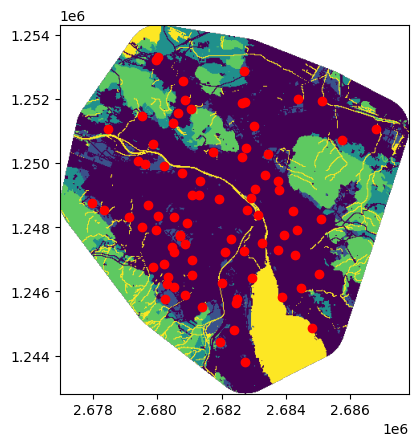

In [ ]:
bird_gdf = gpd.read_file(species_richness_filepath)
# bird_gdf.head()

fig, ax = plt.subplots()
with rio.open(lulc_filepath) as src:
    plot.show(src, ax=ax)
bird_gdf.plot(ax=ax, color="r")
# cx.add_basemap(ax, crs=bird_gdf.crs)

## 2. Multi-scale analysis

We can now instantiate our `MultiScaleAnalysis` object using the LULC raster, site locations and buffer distances:

In [ ]:
msa = pls.MultiScaleAnalysis(lulc_filepath, bird_gdf["geometry"], buffer_dists)

In a `MultiScaleAnalysis`, each landscape is indexed by both the site and buffer distance:

In [ ]:
msa.landscape_ser

site  buffer_dist
0     250            <pylandstats.landscape.Landscape object at 0x7...
      500            <pylandstats.landscape.Landscape object at 0x7...
      750            <pylandstats.landscape.Landscape object at 0x7...
      1000           <pylandstats.landscape.Landscape object at 0x7...
1     250            <pylandstats.landscape.Landscape object at 0x7...
                                           ...                        
80    1000           <pylandstats.landscape.Landscape object at 0x7...
81    250            <pylandstats.landscape.Landscape object at 0x7...
      500            <pylandstats.landscape.Landscape object at 0x7...
      750            <pylandstats.landscape.Landscape object at 0x7...
      1000           <pylandstats.landscape.Landscape object at 0x7...
Length: 328, dtype: object

Since `MultiScaleAnalysis` inherits from `ZonalAnalysis`, we also have the `zone_gser` attribute with the geometries of the landscapes for each site and buffer distance:

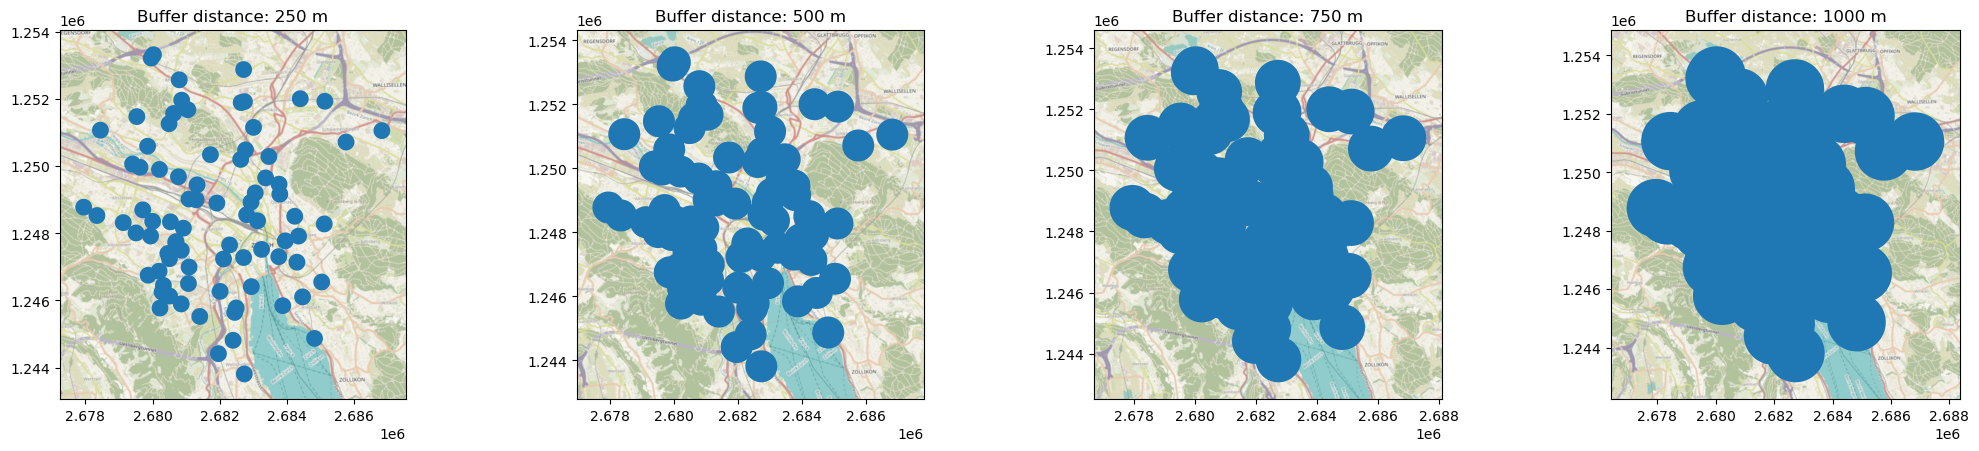

In [ ]:
fig, axes = plt.subplots(
    1, len(buffer_dists), figsize=(figwidth * len(buffer_dists), figheight)
)
for buffer_dist, ax in zip(buffer_dists, axes):
    msa.zone_gser.loc[(slice(None), buffer_dist)].plot(ax=ax)
    ax.set_title(f"Buffer distance: {buffer_dist} m")
    cx.add_basemap(ax, crs=msa.zone_gser.crs, attribution=False)

Even though this is beyond the scope of this notebook, note that overlap between landscapes (as we see for the largest buffer distance) can threaten the assumption of statistical independence of predictors and thus compromise the validity of statistical inference [6, 7]. Under such circumstances, it is important to diagnose issues of spatial autocorrelations and use modeling methods to accomodate for spatial dependencies [1, 8, 9].

Like in most pylandstats classes, we can now use the `compute_landscape_metrics_df` and `compute_class_metrics_df` to respectively compute landscape and class-level metrics:

In [ ]:
landscape_metrics = ["shannon_diversity_index", "area_mn"]
landscape_metrics_df = msa.compute_landscape_metrics_df(
    metrics=landscape_metrics,
)
landscape_metrics_df.head()

[####                                    ] | 12% Completed | 214.25 ms

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


[##########                              ] | 27% Completed | 427.25 ms

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


[###############                         ] | 37% Completed | 642.19 ms

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


[####################                    ] | 51% Completed | 892.18 ms

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in 

[##########################              ] | 66% Completed | 1.10 s ms

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in 

[###############################         ] | 78% Completed | 1.31 s

/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


[########################################] | 100% Completed | 1.75 s


/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(
/home/martibosch/libraries/pylandstats/src/pylandstats/landscape.py:3533: RuntimeWarning: Entropy-based metrics can only be computed in landscapes with at least two classes of patches. Returning nan
  warnings.warn(


shannon_diversity_index    area_mn
site buffer_dist                                    
0    250                         0.036643   9.750000
     500                         0.216805   8.701389
     750                         0.208008  12.607143
     1000                        0.350490   6.670213
1    250                         0.178100   4.921875

The resulting landscape-level data frame is indexed by both the site and buffer distances. For the class-level data frame, an additional index level for the classes is added, which we can ["unstack"](https://pandas.pydata.org/docs/user_guide/reshaping.html#stack-and-unstack) into the columns:

In [ ]:
class_metrics = ["proportion_of_landscape"]
class_metrics_df = msa.compute_class_metrics_df(metrics=class_metrics)

class_metrics_df = class_metrics_df.unstack(level="class_val", fill_value=0)
class_metrics_df.columns = class_metrics_df.columns.to_flat_index().map(
    lambda col: f"{col[0]}-{col[1]}"
)
class_metrics_df.head()

[########################################] | 100% Completed | 621.65 ms


proportion_of_landscape-1  proportion_of_landscape-2  \
site buffer_dist                                                         
0    250                          99.038462                   0.000000   
     500                          95.131684                   1.037510   
     750                          95.573654                   1.239377   
     1000                         92.284689                   3.189793   
1    250                          95.873016                   0.000000   

                  proportion_of_landscape-3  proportion_of_landscape-4  \
site buffer_dist                                                         
0    250                           0.000000                   0.000000   
     500                           0.000000                   0.000000   
     750                           0.000000                   0.000000   
     1000                          0.737640                   0.618022   
1    250                           0.634921                   0.000000   

                  proportion_of_landscape-5  
site buffer_dist                             
0    250                           0.961538  
     500                           3.830806  
     750                           3.186969  
     1000                          3.169856  
1    250                           3.492063

Since both data frames now have the same index, we can concatenate their columns into a single data frame, which will be the dataset matrix in which each row is a landscape (specific to a site and buffer distance) represented by a feature vector of landscape metrics (in fact, equivalent to a [spatial signature](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/05-spatial-signature-analysis.ipynb)):

In [ ]:
metrics_df = pd.concat([landscape_metrics_df, class_metrics_df], axis="columns")
metrics_df.head()

shannon_diversity_index    area_mn  \
site buffer_dist                                       
0    250                         0.036643   9.750000   
     500                         0.216805   8.701389   
     750                         0.208008  12.607143   
     1000                        0.350490   6.670213   
1    250                         0.178100   4.921875   

                  proportion_of_landscape-1  proportion_of_landscape-2  \
site buffer_dist                                                         
0    250                          99.038462                   0.000000   
     500                          95.131684                   1.037510   
     750                          95.573654                   1.239377   
     1000                         92.284689                   3.189793   
1    250                          95.873016                   0.000000   

                  proportion_of_landscape-3  proportion_of_landscape-4  \
site buffer_dist                                                         
0    250                           0.000000                   0.000000   
     500                           0.000000                   0.000000   
     750                           0.000000                   0.000000   
     1000                          0.737640                   0.618022   
1    250                           0.634921                   0.000000   

                  proportion_of_landscape-5  
site buffer_dist                             
0    250                           0.961538  
     500                           3.830806  
     750                           3.186969  
     1000                          3.169856  
1    250                           3.492063

### Scale of effect

The *scale of effect* is the scale at which the relationship between the ecological process and the landscape spatial patterns show its strongest effect [2]. It is possible to statistically estimate the *scale of effect*, e.g., by exploring at which scale the selected model exhibits the strongest determination [3]:

<Axes: xlabel='Buffer dist.', ylabel='AIC'>

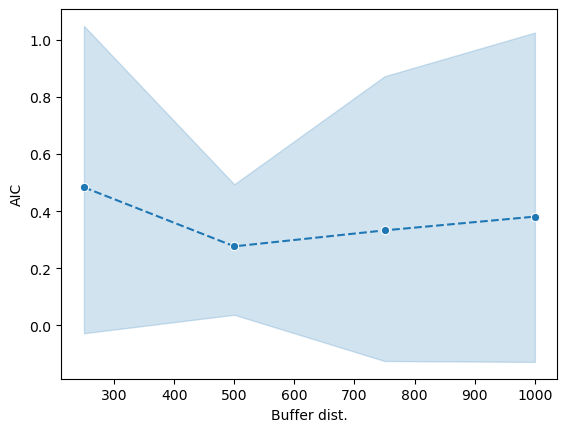

In [ ]:
n_repetitions = 10
test_size = 0.33

# model
model = ensemble.GradientBoostingRegressor
# model = gpb.GPBoostRegressor()
# fit_kwargs = dict(gp_model=gpb.GPModel(likelihood="poisson"))

results = []
y = bird_gdf["n.species"]


for buffer_dist, df in metrics_df.groupby(level="buffer_dist"):
    # drop nan
    df = df.dropna()
    _y = y.loc[df.index.get_level_values("site")]
    for i in range(n_repetitions):
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            df, _y, test_size=test_size, shuffle=True
        )
        results.append((buffer_dist, i, aic(model, X_train, y_train, X_test, y_test)))
eval_df = pd.DataFrame(results, columns=["Buffer dist.", "repetition", "AIC"])
sns.lineplot(eval_df, x="Buffer dist.", y="AIC", marker="o", linestyle="--")

This would suggest that an appropriate *scale of effect* could be around 500 m, but again this is beyond the scope of this notebook.

### Maximizing landscape variation

In order to improve the statistical significance of the relationships between landscape patterns and the ecological response, the selected sites and scale should cover the maximum possible range of landscape heterogeneity to maximize the variance of independent variables [1].

We can explore this using *scalograms*, i.e., plotting how landscape metrics' attributes respond to changes in scale, which can reveal scale thresholds that maximize landscape heterogeneity [1, 7]. For instance, in line with Pasher et al. (2013) [7], we can plot how the coefficient of variation (CV) of the landscape-level metrics responds to increasing buffer distances:

Text(0, 0.5, 'CV')

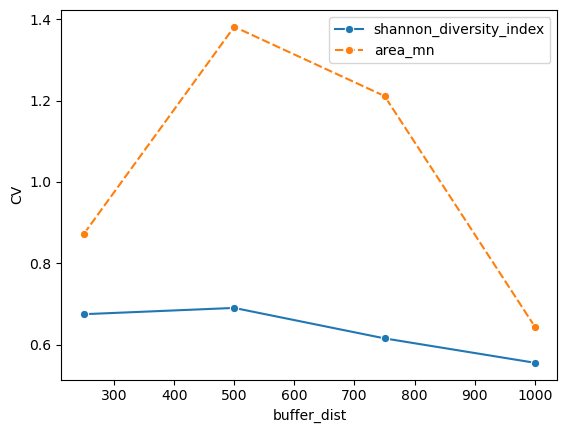

In [ ]:
var_ser = landscape_metrics_df.groupby("buffer_dist").apply(
    variation, nan_policy="omit"
)
ax = sns.lineplot(
    pd.DataFrame(
        [item for item in var_ser],
        columns=landscape_metrics_df.columns,
        index=var_ser.index,
    ),
    marker="o",
)
ax.set_ylabel("CV")

The *scalogram* also suggests that landscape variance (as captured by the two metrics) peaks at the 500 m scale.

### Avoiding confounding

Like in most statistical modeling cases, confounding, namely correlations between predictor variables can lead to weak inferences. To that end, we can explore the relationships between the metrics at different scales:

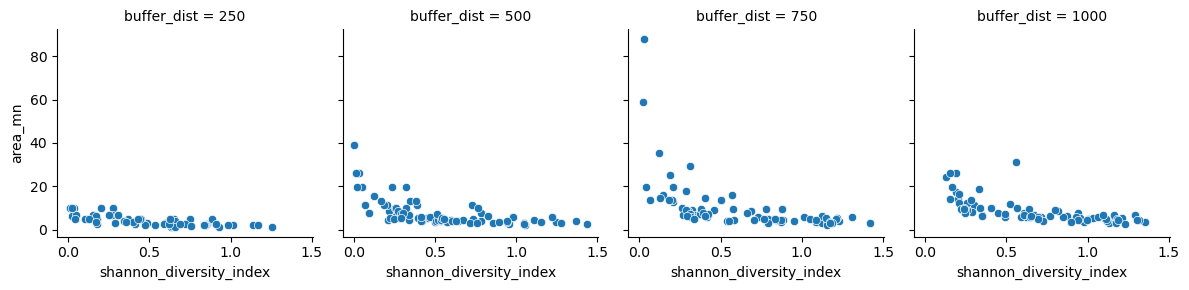

In [ ]:
g = sns.FacetGrid(landscape_metrics_df.reset_index(), col="buffer_dist")
g.map(sns.scatterplot, "shannon_diversity_index", "area_mn")

As we can see, the metrics are increasingly correlated at higher scales (probably due to increasingly overlapping buffers).

#### TODO: explore spatial autocorrelation by plotting Moran's I for each buffer distance over lag distances, e.g., like figure 6 of Pasher et al. (2013) [7].

## References

1. Hesselbarth, M. H., Nowosad, J., de Flamingh, A., Simpkins, C. E., Jung, M., Gerber, G., & Bosch, M. (2025). Computational Methods in Landscape Ecology. Current Landscape Ecology Reports, 10(1), 1-18.
2. Jackson, H. B., & Fahrig, L. (2015). Are ecologists conducting research at the optimal scale?. Global Ecology and Biogeography, 24(1), 52-63.
3. Huais, P. Y. (2024). Multilandr: An r package for multi-scale landscape analysis. Landscape Ecology, 39(8), 140.
4. Casanelles-Abella, J., Chauvier, Y., Zellweger, F., Villiger, P., Frey, D., Ginzler, C., ... & Pellissier, L. (2021). Applying predictive models to study the ecological properties of urban ecosystems: A case study in Zürich, Switzerland. Landscape and Urban Planning, 214, 104137.
5. Giuliani, G., Rodila, D., Külling, N., Maggini, R., & Lehmann, A. (2022). Downscaling Switzerland land use/land cover data using nearest neighbors and an expert system. Land, 11(5), 615.
6. Eigenbrod, F., Hecnar, S. J., & Fahrig, L. (2011). Sub-optimal study design has major impacts on landscape-scale inference. Biological Conservation, 144(1), 298-305.
7. Pasher, J., Mitchell, S. W., King, D. J., Fahrig, L., Smith, A. C., & Lindsay, K. E. (2013). Optimizing landscape selection for estimating relative effects of landscape variables on ecological responses. Landscape ecology, 28, 371-383.
8. F. Dormann, C., M. McPherson, J., B. Araújo, M., Bivand, R., Bolliger, J., Carl, G., ... & Wilson, R. (2007). Methods to account for spatial autocorrelation in the analysis of species distributional data: a review. Ecography, 30(5), 609-628.
9. Zuckerberg, B., Cohen, J. M., Nunes, L. A., Bernath-Plaisted, J., Clare, J. D., Gilbert, N. A., ... & Desrochers, A. (2020). A review of overlapping landscapes: pseudoreplication or a red herring in landscape ecology?. Current Landscape Ecology Reports, 5, 140-148.